# AnyoneAI - Sprint Project 02
> Home Credit Default Risk

You've been learning a lot about Machine Learning Algorithms, now we you're gonna be asked to put it all togheter. 

You will create a complete pipeline to preprocess the data, train your model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.


## 1. Introduction

This is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay their debt or not. Our model will have to predict a 1 indicating the client will have payment difficulties: he/she will have late payment of more than X days on at least one of the first Y installments of the loan in our sample, 0 in all other cases.

The dataset is composed of multiple files with different information about loans taken. In this project, we will work exclusively with the primary files: `application_train_aai.csv` and `application_test_aai.csv`.

We will use [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

In [2]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.validation import check_is_fitted

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src import config, data_utils, preprocessing

### Getting the data

To access the data for this project, you only need to execute the code below. This will download three files inside the `dataset` folder:

- `application_train_aai.csv`: Training dataset you must use to train and find the best hyperparameters on your model.

- `application_test_aai.csv`: Test dataset without labels. Because of the absence of labels, you can't use this dataset for your experiments. You will use the file only at the end after you choose what you think is the best model for the tasks. You will have to use that model to fill values in the `TARGET` column using the model predictions. Then submit this dataset alongside this Jupyter notebook, AnyoneAI will internally evaluate your model's accuracy in the hidden data and communicate later ;).

- `HomeCredit_columns_description.csv`: This file contains descriptions for the columns in train and test datasets.


1.1. Load the training and test datasets. Also, the auxiliary file `HomeCredit_columns_description.csv` has additional information about the features in the dataset.

**Don't change anything in this cell, just make it run correctly**

In [3]:
app_train, app_test, columns_description = data_utils.get_datasets()


if app_train.shape == (246008, 122):
    print("Success: app_train shape is correct!")
else:
    raise ValueError("Train dataset shape is incorrect, please review your code")

if isinstance(app_train, pd.DataFrame):
    print("Success: app_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if app_test.shape == (61503, 122):
    print("Success: app_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(app_test, pd.DataFrame):
    print("Success: app_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

Success: app_train shape is correct!
Success: app_train type is correct!
Success: app_test shape is correct!
Success: app_test type is correct!


### Exploratory Data Analysis

A lot of the analysis of the data can be found on publicly available Kaggle kernels or blog posts, but you need to make sure you understand the dataset's properties before starting working on it, so we'll do exploratory data analysis for the main files.

#### Dataset Basics

1.2. Print how many samples do we have in our train and test datasets.

In [4]:
# 1.2 Print how many samples we have in our train and test datasets
# We already loaded app_train and app_test in the previous step
# Each DataFrame's shape returns a tuple: (number_of_rows, number_of_columns)
train_rows, train_cols = app_train.shape  # Unpack training dataset shape into row and column counts
print(f"Training set: {train_rows} samples, {train_cols} columns")  # Display training set size

test_rows, test_cols = app_test.shape  # Unpack test dataset shape into row and column counts
print(f"Test set: {test_rows} samples, {test_cols} columns")  # Display test set size

Training set: 246008 samples, 122 columns
Test set: 61503 samples, 122 columns


1.3. List all columns in the train dataset.

In [5]:
# 1.3 List all columns in the training dataset with an index
# Get the ordered list of column names from the training DataFrame
columns = app_train.columns.tolist()  # Extract column labels as a Python list

# Print a header line for clarity
print(f"Total columns: {len(columns)}")  # Show how many feature columns exist
print("Index  Column Name")  # Simple header for the listing
print("-----  ------------------------------")  # Visual separator

# Iterate through the list and print each column with a 1-based index
for i, col in enumerate(columns, start=1):  # enumerate provides (index, name)
    print(f"{i:5d}  {col}")  # Right-align index in 5 spaces for neat alignment

Total columns: 122
Index  Column Name
-----  ------------------------------
    1  SK_ID_CURR
    2  TARGET
    3  NAME_CONTRACT_TYPE
    4  CODE_GENDER
    5  FLAG_OWN_CAR
    6  FLAG_OWN_REALTY
    7  CNT_CHILDREN
    8  AMT_INCOME_TOTAL
    9  AMT_CREDIT
   10  AMT_ANNUITY
   11  AMT_GOODS_PRICE
   12  NAME_TYPE_SUITE
   13  NAME_INCOME_TYPE
   14  NAME_EDUCATION_TYPE
   15  NAME_FAMILY_STATUS
   16  NAME_HOUSING_TYPE
   17  REGION_POPULATION_RELATIVE
   18  DAYS_BIRTH
   19  DAYS_EMPLOYED
   20  DAYS_REGISTRATION
   21  DAYS_ID_PUBLISH
   22  OWN_CAR_AGE
   23  FLAG_MOBIL
   24  FLAG_EMP_PHONE
   25  FLAG_WORK_PHONE
   26  FLAG_CONT_MOBILE
   27  FLAG_PHONE
   28  FLAG_EMAIL
   29  OCCUPATION_TYPE
   30  CNT_FAM_MEMBERS
   31  REGION_RATING_CLIENT
   32  REGION_RATING_CLIENT_W_CITY
   33  WEEKDAY_APPR_PROCESS_START
   34  HOUR_APPR_PROCESS_START
   35  REG_REGION_NOT_LIVE_REGION
   36  REG_REGION_NOT_WORK_REGION
   37  LIVE_REGION_NOT_WORK_REGION
   38  REG_CITY_NOT_LIVE_CITY
   39

1.4. Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

For reference only, it should look like this:

|0|1|2|3|4
|---|---|---|---|---
Unnamed: 0|187399|84777|268140|270686|33785
SK_ID_CURR|317244|198357|410700|413785|139141
TARGET|0|0|0|0|0
NAME_CONTRACT_TYPE|Cash loans|Cash loans|Cash loans|Cash loans|Cash loans
...|...|...|...|...|...
AMT_REQ_CREDIT_BUREAU_DAY|0.0|0.0|0.0|0.0|0.0

In [33]:
# 1.4 Show first 5 training records (transposed: features as rows, samples as columns)
# Grab the first 5 rows from the training dataset
first_five = app_train.head(5)  # DataFrame with 5 sample rows

# Transpose so each feature becomes a row, each sample becomes a column
transposed = first_five.T  # Swap axes (rows <-> columns)

# Basic integrity checks
assert transposed.shape[1] == 5, "Expected exactly 5 sample columns after transpose"

# Print a compact shape summary
print(f"Transposed shape (features x samples): {transposed.shape[0]} x {transposed.shape[1]}")  # Expect (#features, 5)

# Ensure we actually show every feature (row) without truncation, then restore prior setting
_prev_max_rows = pd.get_option("display.max_rows")  # Save current display limit
try:
    pd.set_option("display.max_rows", None)  # Temporarily allow unlimited rows
    display(transposed)  # Rich display: features down, sample indices across columns 0..4
finally:
    pd.set_option("display.max_rows", _prev_max_rows)  # Always restore previous option


Transposed shape (features x samples): 122 x 5


,0,1,2,3,4
SK_ID_CURR,428247,140966,407283,434300,446788
TARGET,0,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,F,M,F,F,F
FLAG_OWN_CAR,N,Y,N,N,N
FLAG_OWN_REALTY,N,Y,Y,N,N
CNT_CHILDREN,0,1,0,0,0
AMT_INCOME_TOTAL,157500.0,90000.0,405000.0,90000.0,67500.0
AMT_CREDIT,634500.0,1223010.0,540000.0,439740.0,323388.0
AMT_ANNUITY,30523.5,51948.0,27000.0,18630.0,18054.0


1.5. Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

Target variable distribution (0 = no difficulty, 1 = payment difficulty):
    Count  Percent
0  226257    91.97
1   19751     8.03


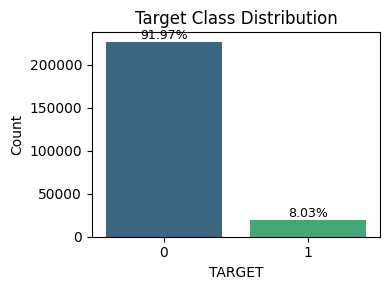

In [7]:
# 1.5 Distribution of the target variable (class balance)
# Select the target column from the training dataset
target_series = app_train['TARGET']  # Series of 0/1 labels

# Count absolute occurrences of each class (0 = no default, 1 = default)
class_counts = target_series.value_counts().sort_index()  # Ensures index order 0,1

# Compute percentage representation for each class
class_percent = (class_counts / len(target_series) * 100).round(2)  # Percent with 2 decimals

# Combine counts and percentages into a single DataFrame for neat display
summary_df = pd.DataFrame({
    'Count': class_counts,  # Absolute counts per class
    'Percent': class_percent  # Percentage per class
})

# Print a header for clarity
print("Target variable distribution (0 = no difficulty, 1 = payment difficulty):")  # Context for the reader
print(summary_df)  # Show the table with counts and percentages

# Basic sanity checks to ensure we have exactly two classes and counts add up
assert summary_df.shape[0] == 2, "Unexpected number of target classes"  # Expect binary target
assert summary_df['Count'].sum() == len(target_series), "Counts do not sum to dataset length"  # Integrity check

# Plot the distribution using a bar plot
fig, ax = plt.subplots(figsize=(4, 3))  # Small figure for compactness
sns.barplot(x=summary_df.index, y=summary_df['Count'], palette='viridis', ax=ax)  # Bar chart of counts
ax.set_xlabel('TARGET')  # X-axis label
ax.set_ylabel('Count')  # Y-axis label
ax.set_title('Target Class Distribution')  # Plot title

# Annotate each bar with percentage above it
for patch, pct in zip(ax.patches, summary_df['Percent']):  # Iterate bars and percentages
    ax.text(
        patch.get_x() + patch.get_width() / 2,  # Horizontal center of bar
        patch.get_height(),  # Top of bar
        f"{pct}%",  # Percentage label
        ha='center', va='bottom', fontsize=9  # Center alignment, small font
    )

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Render the plot

1.6. Show the number of columns of each data type.

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
float64    45
int64      32
object     10
```

In [11]:
# 1.6 Show the number of columns of each data type (single clean output)
# Extract the dtype Series from the training DataFrame
dtypes = app_train.dtypes  # pandas Series: column_name -> dtype

# Aggregate counts per dtype
dtype_counts = dtypes.value_counts()  # Unique dtype -> number of columns

# Build a summary DataFrame with counts and percentage share
dtype_summary = (dtype_counts
                 .to_frame(name='Count')  # Convert to DataFrame with column name 'Count'
                )

# Print a concise header (avoid duplicating detailed lines below)
print("Number of columns per data type (training dataset):")  # Context header

# Display the summary table only once (prevents duplicated appearance)
display(dtype_summary)  # Jupyter-friendly formatted table

Number of columns per data type (training dataset):


,Count
float64,65
int64,41
object,16


1.7. For categorical variables (`object` data type), show the number of distinct values in each column (number of labels).

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
NAME_CONTRACT_TYPE             5
CODE_GENDER                    2
FLAG_OWN_CAR                   1
FLAG_OWN_REALTY                1
...
```

In [ ]:
# 1.7 Number of distinct values per categorical column (object / category dtypes)
# Select columns whose dtype is object or category so we cover raw strings and already-converted categoricals
categorical_cols = app_train.select_dtypes(include=['object', 'category']).columns.tolist()  # List of categorical feature names

# Compute the number of unique (non-null) labels for each categorical feature
unique_counts = app_train[categorical_cols].nunique(dropna=True)  # Series: column_name -> distinct value count

# Choose ordering: ascending (low-cardinality first) can help spot binary flags quickly.
# If you prefer high-cardinality first, change ascending=True to False.
unique_counts_sorted = unique_counts.sort_values(ascending=False)  # Reordered Series by distinct count

# Print a concise header for context
print(f"Total categorical columns: {len(categorical_cols)}")  # How many categorical features we processed
print("Column Name                           UniqueValues")  # Header row labels
print("---------------------------------------------------")  # Visual separator

# Iterate through sorted counts and print each column name with its unique value count
for col, n in unique_counts_sorted.items():  # Loop gives (column_name, unique_count)
    print(f"{col:35s} {n:5d}")  # Fixed-width column name (35 chars) and right-aligned count (5 width)

Total categorical columns: 16
Column Name                           UniqueValues
---------------------------------------------------
ORGANIZATION_TYPE                      58
OCCUPATION_TYPE                        18
NAME_INCOME_TYPE                        8
NAME_TYPE_SUITE                         7
WEEKDAY_APPR_PROCESS_START              7
WALLSMATERIAL_MODE                      7
NAME_FAMILY_STATUS                      6
NAME_HOUSING_TYPE                       6
NAME_EDUCATION_TYPE                     5
FONDKAPREMONT_MODE                      4
CODE_GENDER                             3
HOUSETYPE_MODE                          3
NAME_CONTRACT_TYPE                      2
FLAG_OWN_CAR                            2
FLAG_OWN_REALTY                         2
EMERGENCYSTATE_MODE                     2


1.8. Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

Just for giving you an idea, the output should look like this (not exactly the same numbers and columns names):

```python
                   Total   Percent
COMMONAREA_AVG    121000      85.2
COMMONAREA_MODE   121000      76.6
COMMONAREA_MEDI   121000      62.9
...
```

In [27]:
# 1.8 Missing data analysis (top 20 columns by missing percentage)
# Store total number of rows once for reuse
total_rows = len(app_train)  # Total samples in training set

# Count missing (NaN) values per column
missing_counts = app_train.isna().sum()  # Series: column_name -> number of NaNs

# Keep only columns that actually have at least one missing value
missing_counts = missing_counts[missing_counts > 0]  # Filter out fully complete columns

# If there are no missing values, report and skip further processing
if missing_counts.empty:  # Check if Series has length 0
    print("No missing values found in the training dataset.")  # Informative message
else:
    # Compute percentage of missing values for each column
    missing_percent = (missing_counts / total_rows * 100).round(1)  # Percent with 2 decimals

    # Combine counts and percentages into a single DataFrame
    missing_df = (pd.DataFrame({
        'Total': missing_counts,     # Absolute count of NaNs
        'Percent': missing_percent          # Percentage of NaNs
    })
    .sort_values('Percent', ascending=False)  # Order columns by descending missing percentage
    )

    # Select only the top 20 columns with the highest missing percentage
    top20 = missing_df.head(20)  # Truncate to first 20 rows

    # Display the resulting table for quick inspection
    display(top20)  # Nicely formatted output in Jupyter

,Total,Percent
COMMONAREA_MEDI,172189,70.0
COMMONAREA_AVG,172189,70.0
COMMONAREA_MODE,172189,70.0
NONLIVINGAPARTMENTS_MEDI,171096,69.5
NONLIVINGAPARTMENTS_MODE,171096,69.5
NONLIVINGAPARTMENTS_AVG,171096,69.5
LIVINGAPARTMENTS_MODE,168494,68.5
LIVINGAPARTMENTS_MEDI,168494,68.5
LIVINGAPARTMENTS_AVG,168494,68.5
FONDKAPREMONT_MODE,168561,68.5


#### Analyzing distribution of variables

1.9. Show the distribution of credit amounts.

*Hint:* Take a look at `AMT_CREDIT` column.

In [ ]:
### TODO Complete in this cell: distribution of credit amounts


1.10. Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

*Hint:* Take a look at `NAME_EDUCATION_TYPE` column.

In [ ]:
### TODO Complete in this cell: level of education plot


1.11. Plot the distribution of ocupation of the loan applicants.

*Hint:* Take a look at `OCCUPATION_TYPE` column.

In [ ]:
### TODO Complete in this cell: ocupation of applicants


1.12. Plot the family status of the applicants.

*Hint:* Take a look at `NAME_FAMILY_STATUS` column.

In [ ]:
### TODO Complete in this cell: family status


1.13. Plot the income type of applicants grouped by the target variable.

*Hint:* Take a look at `NAME_INCOME_TYPE` and `TARGET` columns. You can use `hue` parameter on Seaborn to group samples using another categorical feature.

In [ ]:
### TODO Complete in this cell: Income type of applicants by target variable


## 2. Preprocessing

2.1. The next step will be to separate our train and test datasets columns between Features (the input to the model) and Targets (what the model has to predict with the given features).

- Assign to `X_train` all the columns from `app_train` that should be used as features for training our models.
- Assign to `y_train` the single column from `app_train` that should be used as our target (i.e. what we want to predict).
- Assign to `X_test` all the columns from `app_test` that should be used as features for training our models.
- Assign to `y_test` the single column from `app_test` that should be used as our target (i.e. what we want to predict).

To do that, you will have to complete the function `data_utils.get_feature_target()` in all the parts with a `TODO` mark.


**Don't change anything in this cell, just make it run correctly**

In [ ]:
# Now we execute the function above to get the result
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)


if X_train.shape == (246008, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (246008,) or y_train.shape == (246008, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_test.shape == (61503, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_test, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_test.shape == (61503,) or y_test.shape == (61503, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

2.2. In order to avoid overfitting while searching for the best model hyperparameters, it's always a good idea to split our training dataset into two new sets called `train` and `validation`. 

While the `train` data will be used to fit the model and adjust its internal weights, the `validation` will be exclusively used to test the model performance on unseen data during training, it's like a testing dataset used during experimentation.

Remember we can't use the `test` dataset to validate the model performance because this one lacks of labels :( So the `validation` data will be the only resource you will have to evaluate the final model performance before doing your submission.

To do that, you will have to complete the function `data_utils.get_train_val_sets()` in all the parts with a `TODO` mark.

This function should perform these activities:
- Use the `sklearn.model_selection.train_test_split` function with `X_train`, `y_train` datasets.
- Assign only 20% of the dataset for testing (see `test_size` parameter in `train_test_split`)
- Assign a seed so we get reproducible output across multiple function calls (see `random_state` parameter in `train_test_split`)
- Shuffle the data (see `shuffle` parameter in `train_test_split`)

For reference, see:
- [Scikit-learn train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [Wikipedia: Training, validation, and test data sets](https://en.wikipedia.org/wiki/Training,_validation,_and_test_data_sets)
- [Train Test Validation Split: How To & Best Practices](https://www.v7labs.com/blog/train-validation-test-set)


**Don't change anything in this cell, just make it run correctly**

In [ ]:
# Now we execute the function above to get the result
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)


if X_train.shape == (196806, 121):
    print("Success: X_train shape is correct!")
else:
    raise ValueError("X_train dataset shape is incorrect, please review your code")

if isinstance(X_train, pd.DataFrame):
    print("Success: X_train type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if y_train.shape == (196806,) or y_train.shape == (196806, 1):
    print("Success: y_train shape is correct!")
else:
    raise ValueError("Train labels shape is incorrect, please review your code")

if X_val.shape == (49202, 121):
    print("Success: X_test shape is correct!")
else:
    raise ValueError("Test dataset shape is incorrect, please review your code")

if isinstance(X_val, pd.DataFrame):
    print("Success: X_test type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

if y_val.shape == (49202,) or y_val.shape == (49202, 1):
    print("Success: y_test shape is correct!")
else:
    raise ValueError("Test labels shape is incorrect, please review your code")

2.3. In this section, you will code a function to make all the data pre-processing for the dataset. What you have to deliver is a function that takes `X_train`, `X_val`, and `X_test` dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function should perform these activities, in this order:

1. Correct outliers/anomalous values in numerical columns (`DAYS_EMPLOYED` column)
2. Encode string categorical features (dytpe `object`):
    - If the feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
3. Impute values for all columns with missing data (use median as imputing value)
4. Feature scaling with Min-Max scaler.

Complete the function `preprocessing.preprocess_data()` following the instructions given above.

In the following cell, we are going to execute the preprocessing function you've just coded. No need to modify this.

**Important Note:** From now on, you must always use `train_data` for training your models and `val_data` only for the final evaluation of the model trained. About `test_data`, it will be used at the end only for submitting your final model predictions and be evaluated on our side with the hidden annotations.


**Don't change anything in this cell, just make it run correctly**

In [ ]:
train_data, val_data, test_data = preprocessing.preprocess_data(X_train, X_val, X_test)


if train_data.shape == (196806, 246):
    print("Success: train_data shape is correct!")
else:
    raise ValueError("train_data dataset shape is incorrect, please review your code")

if isinstance(train_data, np.ndarray):
    print("Success: train_data type is correct!")
else:
    raise ValueError("Train dataset type is incorrect, please review your code")

if val_data.shape == (49202, 246):
    print("Success: val_data shape is correct!")
else:
    raise ValueError("val_data dataset shape is incorrect, please review your code")

if isinstance(val_data, np.ndarray):
    print("Success: val_data type is correct!")
else:
    raise ValueError("Validation dataset type is incorrect, please review your code")

if test_data.shape == (61503, 246):
    print("Success: test_data shape is correct!")
else:
    raise ValueError("test_data dataset shape is incorrect, please review your code")

if isinstance(test_data, np.ndarray):
    print("Success: test_data type is correct!")
else:
    raise ValueError("Test dataset type is incorrect, please review your code")

## 3. Training Models

As usual, you will start training simple models and will progressively move to more complex models and pipelines.

**Pro tip:** It is of utmost importance to make an accurate estimation of the time required to train a machine learning model. Because of this, we recommend you to use Python [time](https://docs.python.org/3/library/time.html) library or Jupyter magic function `%%time` on the cell you're training your model to get an estimate of the time it took to fit your data.

### Baseline: LogisticRegression

3.1. Import LogisticRegression from sklearn and train a model using the preprocesed train data from the previous section, and just default parameters. If you receive a warning because the algorithm failed to converge, try increasing the number of iterations or decreasing the C parameter.

Assign the trained model to `log_reg` variable.

**Don't change anything in this cell, just make it run correctly**

In [ ]:
%%time

# This is an example code on how to:
#   - Create and fit (train) a logistic regression
#   - Assign to `log_reg` variable
log_reg = None
log_reg = LogisticRegression(C=0.0001)
log_reg.fit(train_data, y_train)

**Don't change anything in this cell, just make it run correctly**

In [ ]:
if isinstance(log_reg, LogisticRegression):
    print("Success: Logistic regression model type is correct!")
else:
    raise ValueError(
        "Logistic regression model type is incorrect, please review your code"
    )

check_is_fitted(log_reg)

3.2. Use the trained model to predict probabilities for `train_data` and `val_data`.

**Important note:** When using the function `predict_proba()` for getting model probabilities you will get, for each sample, a tuple indicating the probability for class 0 and for class 1 respectively. For computing the AUC ROC score we only need the probability that the debt is not repaid (equivalent to class 1). As an example, the result from running `predict_proba()` on validation dataset will have a shape of `(49202, 2)` but, we only need the second column from that matrix, which corresponds to the class 1.


**Don't change anything in this cell, just make it run correctly**

In [ ]:
# Example code to show you how to use the Logistic Regression model
# to predict probabilities for each class and then, use the probabilities for the
# class 1 only.

# Train data predictions (class 1)
log_reg_train = log_reg.predict_proba(train_data)[:, 1]

# Validation data predictions (class 1)
log_reg_val = log_reg.predict_proba(val_data)[:, 1]

3.3. Get AUC ROC score on train and validation datasets. See [scikit-learn AUC ROC function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html) for a working implementation.

Assign the AUC ROC score to `lr_roc_auc` variable.


**Don't change anything in this cell, just make it run correctly**

In [ ]:
# Example code to show you how to get the ROC AUC Score on train and val datasets

# Train ROC AUC Score
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)
print(f"Train ROC AUC Score: {roc_auc_train:.4f}")

# Validation ROC AUC Score
roc_auc_val = roc_auc_score(y_true=y_val, y_score=log_reg_val)
print(f"Validation ROC AUC Score: {roc_auc_val:.4f}")

At this point, the model should produce a result of around 0.67.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

**Don't change anything in this cell, just make it run correctly**

In [ ]:
if isinstance(roc_auc_val, float):
    print("Success: AUC ROC score type is correct!")
else:
    raise ValueError("AUC ROC score type is incorrect, please review your code")

if roc_auc_val >= 0.6:
    print("Success: AUC ROC score is correct!")
else:
    raise ValueError("AUC ROC score is incorrect, please review your code")

### Training a Random Forest Classifier 

You're gonna start working in more complex models: ensambles, particularly, you're going to use the Random Forest Classifier from Scikit Learn. 

3.4. Train a RandomForestClassifier, print the time taken by the fit function. Just use default hyperparameters, except for `n_jobs`, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [ ]:
%%time

# TODO Write your code here for training a Random Forest model.
#   - Please use sklearn.ensemble.RandomForestClassifier() class.
#   - Assign the model to the variable `rf`.
#   - Remember to fit the model only on `train_data`.
rf = 


**Don't change anything in this cell, just make it run correctly**

In [ ]:
if isinstance(rf, RandomForestClassifier):
    print("Success: RandomForestClassifier model type is correct!")
else:
    raise ValueError(
        "RandomForestClassifier model type is incorrect, please review your code"
    )

check_is_fitted(rf)

3.5. Use the classifier to predict probabilities for `train_data` and `val_data`.

In [ ]:
# TODO Use the Random Forest model to predict probabilities for each class and then,
# use the probabilities for the class 1 only.

# Train data predictions (class 1)
rf_pred_train = 

# Validation data predictions (class 1)
rf_pred_val = 

3.6. Get AUC ROC score on train and validation datasets.


In [ ]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score
roc_auc_train = 

# Validation ROC AUC Score
roc_auc_val = 

At this point, the model should produce a result around 0.7.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

### Randomized Search with Cross Validation

So far, we've only created models using the default hyperparameters of each algorithm. This is usually something that we would only do for baseline models, hyperparameter tuning is a very important part of the modeling process and is often the difference between having an acceptable model or not.

But, there are usually lots of hyperparameters to tune and a finite amount of time to do it, you have to consider the time and resources it takes to find an optimal combination of them. In the previous section you trained a random forest classifier and saw how much it took to train it once in your PC. If you want to do hyperparameter optimization you now have to consider that you will have to train the algorithm N number of times, with N being the cartesian product of all parameters. 

Furthermore, you can't validate the performance of your trained models on the test set, as this data should only be used to validate the final model. So we have to implement a validation strategy, K-Fold Cross Validation being the most common. But this also adds time complexity to our training, because we will have to train each combinations of hyperparameters M number of times, X being the number of folds in which we divided our dataset, so the total number of training iterations will be NxM... this resulting number can grow VERY quickly.

Fortunately there are strategies to mitigate this, here you're going to select a small number of hyperparameters to test a RandomForestClassifier, and use a Randomized Search algorithm with K-Fold Cross Validation to avoid doing a full search across the grid. 

Remember: take in consideration how much time it took to train a single classifier, and define the number of cross validations folds and iterations of the search accordingly. 
A recommendation: run the training process, go make yourself a cup of coffee, sit somewhere comfortably and forget about it for a while.


3.7. Use `sklearn.model_selection.RandomizedSearchCV()` to find the best combination of hyperparameters for a Random Forest model. 

The validation metric used to evaluate the models should be "roc_auc" (i.e. `scoring="roc_auc"`).

In [ ]:
%%time

# TODO Write your code here for training a Random Forest model using Random Search
# of hyper-parameters.
#   - Please use sklearn.model_selection.RandomizedSearchCV() and
#     sklearn.ensemble.RandomForestClassifier() classes.
#   - Assign the RandomizedSearchCV model to the variable `rf_random`.
#   - Remember to fit the model only on `train_data`.
rf_random = 


3.8. Use the classifier to predict probabilities on the train and test data.


In [ ]:
# TODO Use the RandomizedSearchCV model to predict probabilities for each class and
# then, use the probabilities for the class 1 only.

# Train data predictions (class 1)
rf_tuned_pred_train =

# Validation data predictions (class 1)
rf_tuned_pred_val =

3.9. Get AUC ROC score on train and validation datasets.

In [ ]:
# TODO Get the ROC AUC Score on train_data and val_data datasets.
# Train ROC AUC Score
roc_auc_train =

# Validation ROC AUC Score
roc_auc_val =

At this point, the model should produce a result around 0.7 or higher.

**Question:** Comparing train and validation results, do you observe underfitting, overfitting, or none of those two?

## 4. Predict unlabeled data

Now it's time to finally use the `test_data` samples. Because we don't have the labels we can't see how the model performs on this dataset (╯°□°)╯︵ ┻━┻

But... don't worry, we will internally evaluate your model and give feedback on the results!

In the cells below:
- Take your best model
- Take `test_data` (i.e. the dataset after doing the preprocessing and feature engineering part)
- Run the data through your model and save the predictions on the `TARGET` column in the `app_test` DataFrame (yeah that we've loaded at the very beginning of this notebook).
    - `TARGET` column values must be the probabilities for class 1. So remember to use the `predict_proba()` function from your model as we did in the previous sections.
- Save the modified version of the DataFrame with the same name it has before (`dataset/application_test_aai.csv`) and don't forget to submit it alongside the rest of this sprint project code
- And finally, don't get confused, you shouldn't submit `dataset/application_train_aai.csv`. So please don't upload your solution with this heavy dataset inside.

Let's say your best model is called `best_credit_model_ever`, then your code should be exactly this:

```python
    test_preds = best_credit_model_ever.predict_proba(test_data)[:, 1]
    app_test["TARGET"] = test_preds
    app_test.to_csv(config.DATASET_TEST, index=False)
```


In [ ]:
%%time

# TODO Use your best model and call the predict_proba() on test_data then,
# use the probabilities for the class 1 only.
# Then, put the predictions in app_test["TARGET"] and save the DataFrame as a csv
# with the same name it originally has ("application_test_aai.csv").


## 5. Optional exercises

### Optional: Training a LightGBM model 

5.1. Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. You can try using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained. 

In [ ]:
### Complete in this cell: train a LightGBM model

### Optional: Using Scikit Learn Pipelines 

5.2. So far you've created special functions or blocks or code to chain operations on data and then train the models. But, reproducibility is important, and you don't want to have to remember the correct steps to follow each time you have new data to train your models. There are a lots of tools out there that can help you with that, here you can use a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process your data.

In [ ]:
### Complete in this cell: use a sklearn Pipeline to automate the cleaning, standardizing and training

### Optional: Build your own model and features

5.3. If you want you can take the original labeled data given and make your own feature selection, data preprocessing, and model tunning. Be creative, the only limit is time and hardware resources. Only be careful and don't modify the previous functions made in the mandatory assignments or, you will break the project tests.

You can even use this newer model to make predictions in the test dataset with hidden labels and submit that.


In [ ]:
### Complete in this cell: Make you own experimentation process